<a href="https://colab.research.google.com/github/tomrodenhagen/pycluster/blob/master/reproduce_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

! rm -r pycluster
! git clone https://github.com/tomrodenhagen/pycluster
! pip install -r pycluster/requirements.txt


rm: cannot remove 'pycluster': No such file or directory
Cloning into 'pycluster'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 80 (delta 39), reused 61 (delta 20), pack-reused 0
Unpacking objects: 100% (80/80), done.


In [2]:
import pickle, os
import numpy as np
import sys
sys.path.append('/content/pycluster')
sys.path.append('/content/pycluster/src')

from metrics import *
from simulation import *
from utils import *
from declustering import *
from fitting import *
install_etas()




/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')
R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘dotCall64’, ‘spatstat.data’, ‘spatstat.utils’, ‘deldir’, ‘abind’, ‘tensor’, ‘polyclip’, ‘spam’, ‘maps’, ‘goftest’, ‘spatstat’, ‘fields’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/dotCall64_1.0-0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 17249 bytes (16 KB)

R[write to console]: =
R[write to console]: =
R[write to console

declustering:
  |======================================================================| 100%
estimating:
declustering:
  |======================================================================| 100%
estimating:
              iteration 2              
0.0115080159 0.0006522581 0.4617450428 
declustering:
  |======================================================================| 100%
estimating:
              iteration 3              
1.196670e-03 5.845099e-05 1.700448e-01 
{'mu': 1.0292613180581809, 'A': 0.08383884477818482, 'c': 0.008494116829893539, 'alpha': 2.513613846164583, 'p': 1.1746840588732408, 'D': 0.0005714651879042716, 'q': 3.6373032707733404, 'gamma': 1.616218061962918} 0.35502183406113536
Length of simulated catalog is 1052


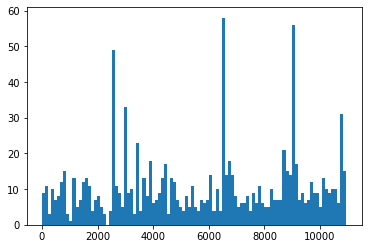

declustering:
  |======================================================================| 100%
estimating:
declustering:
  |======================================================================| 100%
estimating:
              iteration 2              
1.285226e-02 2.552296e-06 3.903249e-01 
declustering:
  |======================================================================| 100%
estimating:
              iteration 3              
3.893490e-03 7.225129e-05 1.406538e-01 
{'mu': 0.709400103355308, 'A': 0.25532032768297985, 'c': 0.03968787152341607, 'alpha': 2.2568605128196313, 'p': 1.1442649599581995, 'D': 0.012250349071287787, 'q': 2.104540514957355, 'gamma': 7.843093851718588e-18} 0.21970260223048324
Length of simulated catalog is 2015


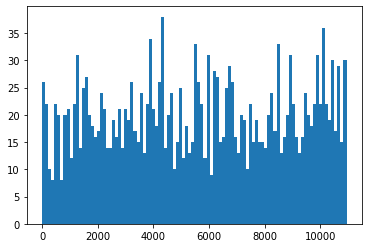

Results per catalogue                                    value
method        metric cat                
ETAS_Known    mae    iran.quakes      13
                     italy.quakes      6
NN            mae    iran.quakes      92
                     italy.quakes     85
Window_method mae    iran.quakes      27
                     italy.quakes      2
Results                        value
method        metric       
ETAS_Known    mae       9.5
NN            mae      88.5
Window_method mae      14.5


In [3]:

from matplotlib import pyplot as plt  


configurations = [ { "cat": "italy.quakes",
                    "lat": (36, 47),
                    "long": (7, 18),
                    "days": 365 * 30,
                    "start":"2005/04/17",
                    "begin":"2005/04/16",
                    "end":" 2013/11/01",
                    "m0": 4.0},
                  { "cat": "iran.quakes",
                    "lat": (26, 40),
                    "long": (44, 63),
                    "days": 365 * 30,
                    "start":"1986/01/01",
                    "begin":"1973/01/01",
                    "end":"2016/01/01",
                    "m0": 4.5}
                 ]

methods = [{"name": "Window_method", "function" : window_method},
           {"name":"NN", "function": NearestNeigbour},
           {"name": "ETAS", "function": from_ETAS},
           {"name": "ETAS_Known", "function": from_ETAS}]
metrics = {"mae":mae,
           }
n_catalogs = 3
res_dic ={}
for conf in configurations:
  catalog = conf["cat"]
  if os.path.exists(f"./{catalog}_estimate.pickle"):
    density, params, beta = pickle.load(open(f"./{catalog}_estimate.pickle", "rb") )
  else:
    density, params, beta = fit_ETAS(**conf)
    pickle.dump( (density, params, beta),  open(f"./{catalog}_estimate.pickle", "wb"))
  print(params, beta)
  mu, mu_max = get_background_intensity_func(density, mu_0 = params["mu"] , **conf)
  res = {method["name"] : {name: [] for name in metrics.keys()} for method in methods}

  for _ in range(n_catalogs):
    simulated_events = simulate_etas(conf["days"], conf["lat"], conf["long"], params, mu, mu_max,conf["m0"], beta  )
    simulated_events = sorted(simulated_events, key= lambda x: x["event"]["t"])
    print(f"Length of simulated catalog is {len(simulated_events)}")
    plt.hist([e["event"]["t"] for e in simulated_events], bins=100)
    plt.show()
    ids = [e["mainshock_id"] for e in simulated_events]
    

    for m in methods:
      if m["name"]=="ETAS_Known":
        conf_fitted = {"fitted":(density, params, beta)}
        conf_fitted.update(conf)
        cluster = m["function"](simulated_events, **conf_fitted )
      else:
        cluster = m["function"](simulated_events, **conf )
      for name, metric in metrics.items():
        res[m["name"]][name].append( metric(ids, cluster) )
  res_dic[conf["cat"]] = res
rows = []
for cat, item in res_dic.items():
      for method, metrics in item.items():
        for metric, values in metrics.items():
          for v in values:
            row = [cat, method, metric, v]
            rows.append(row)
df = pd.DataFrame(rows, columns = ["cat", "method", "metric", "value"])
#Get results
print("Results per catalogue", df.groupby(["method", "metric", "cat"]).mean())
print("Results ", df.groupby(["method", "metric"]).mean())
